Fetching data for symbols: ['AAPL', 'MSFT', 'AMZN', 'PLTR', 'ENPH']


[*********************100%***********************]  5 of 5 completed


'Adj Close' found for AAPL.
'Adj Close' found for MSFT.
'Adj Close' found for AMZN.
'Adj Close' found for PLTR.
'Adj Close' found for ENPH.
Removing timezone information from stock data 'Date' column...
Total Stock Data Rows: 15090
Stock Data Shape: (15090, 4)
Fetching GDP...
Fetching CPI...
Fetching Unemployment_Rate...


C:\Users\Owenc\AppData\Local\Temp\ipykernel_46444\771189193.py:136: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_df = macro_df.sort_values('Date').fillna(method='ffill').fillna(method='bfill')
C:\Users\Owenc\AppData\Local\Temp\ipykernel_46444\771189193.py:189: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean = df.fillna(method='ffill').fillna(method='bfill')


Total Macro Data Rows after Reindexing: 3018
Macro Data Shape: (3018, 4)

--- Merging Stock Data with Macroeconomic Indicators ---
Total Rows after Merge: 15090
Merged Data Shape: (15090, 7)

--- Handling Missing Values ---
Missing Values per Column:
           Missing Count  Missing Percentage
Adj Close           2261           14.983433
Volume              2261           14.983433

Initial Rows: 15090
Final Rows after Handling Missing Values: 15090
Total Rows Dropped: 0
Cleaned Data Shape: (15090, 7)

--- Feature Engineering ---
Feature Engineering Completed.
Data Shape after Feature Engineering: (14845, 13)
Portfolio Volatility Calculated.
HMM Applied. Regime Labels Added.
Regime Labels Merged with Main DataFrame.
Feature Standardization Completed.

Saving data to preprocessed_portfolio_data_with_Regimes.csv...
Data saved successfully.


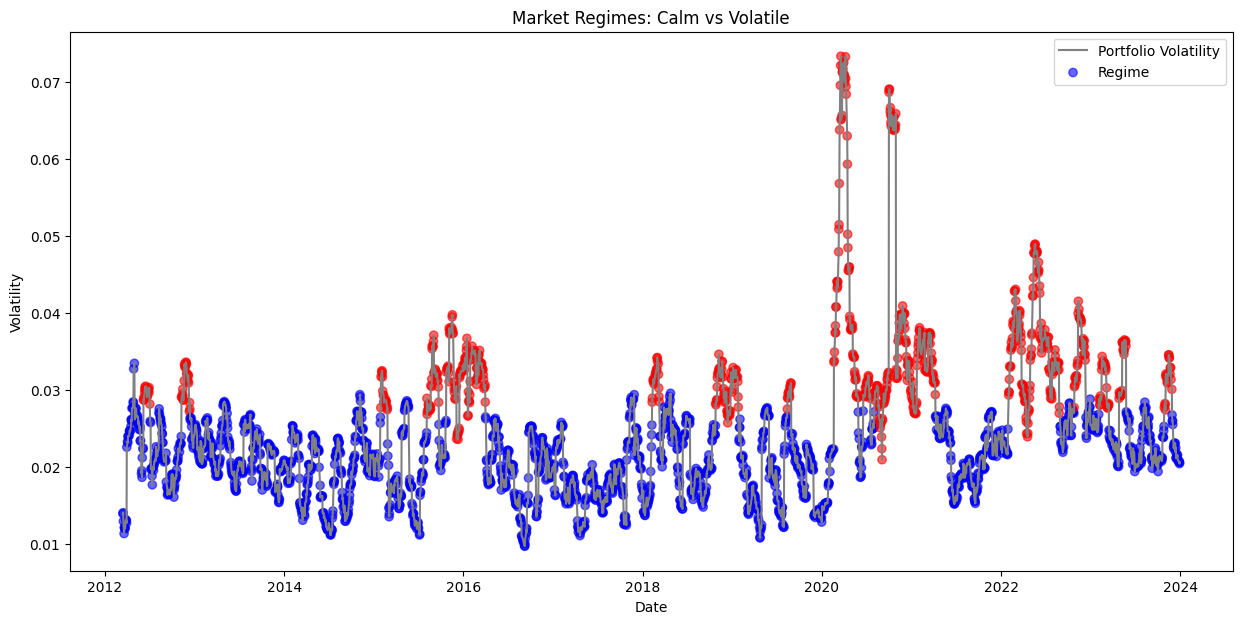


Data Preprocessing Pipeline Completed Successfully.


In [ ]:
# data_preprocessing.py

import os
import numpy as np
import pandas as pd
import yfinance as yf
from fredapi import Fred
from dotenv import load_dotenv
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
import matplotlib.pyplot as plt

# Uncomment if you wish to use GARCH-based volatility
# from arch import arch_model

def fetch_stock_data(symbols, start, end):
    """
    Fetch historical stock data for given symbols within the specified date range using yf.download.
   
    Parameters:
    - symbols (list): List of stock ticker symbols.
    - start (str): Start date in 'YYYY-MM-DD' format.
    - end (str): End date in 'YYYY-MM-DD' format.
   
    Returns:
    - pd.DataFrame: Combined stock data for all symbols with necessary columns.
    """
    print(f"Fetching data for symbols: {symbols}")
    df = yf.download(symbols, start=start, end=end, group_by='ticker', auto_adjust=False, threads=True)
   
    if len(symbols) == 1:
        # If only one symbol, yf.download returns a single DataFrame
        df.columns = pd.MultiIndex.from_product([symbols, df.columns])
   
    # Initialize a list to collect individual DataFrames
    data_frames = []
   
    for symbol in symbols:
        if symbol not in df.columns.get_level_values(0):
            print(f"No data found for {symbol}. Skipping.")
            continue
       
        symbol_df = df[symbol].copy()
       
        # Check if 'Adj Close' exists; if not, set it equal to 'Close'
        if 'Adj Close' not in symbol_df.columns:
            print(f"Missing 'Adj Close' for {symbol}. Setting 'Adj Close' equal to 'Close'.")
            symbol_df['Adj Close'] = symbol_df['Close']
        else:
            print(f"'Adj Close' found for {symbol}.")
       
        # Reset index to bring 'Date' back as a column
        symbol_df.reset_index(inplace=True)
       
        # Add 'Symbol' column
        symbol_df['Symbol'] = symbol
       
        # Select the required columns
        required_columns = ['Date', 'Symbol', 'Adj Close', 'Volume']
        missing_cols = [col for col in required_columns if col not in symbol_df.columns]
        if missing_cols:
            print(f"Missing columns {missing_cols} for {symbol}. Skipping.")
            continue
       
        data_frames.append(symbol_df[required_columns])
   
    if not data_frames:
        raise ValueError("No stock data was fetched. Please check the ticker symbols and date range.")
   
    # Concatenate all symbol DataFrames
    combined_df = pd.concat(data_frames, ignore_index=True)
   
    # Ensure 'Date' is datetime and remove timezone information
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])
    if combined_df['Date'].dt.tz is not None:
        print("Removing timezone information from stock data 'Date' column...")
        combined_df['Date'] = combined_df['Date'].dt.tz_convert(None).dt.tz_localize(None)
    else:
        print("Stock data 'Date' column is already timezone-naive.")
   
    # Sort by Date and Symbol
    combined_df = combined_df.sort_values(['Date', 'Symbol']).reset_index(drop=True)
   
    print(f"Total Stock Data Rows: {combined_df.shape[0]}")
    return combined_df

def fetch_macro_data(fred_client, start, end, trading_dates):
    """
    Fetch macroeconomic indicators from FRED and align them with trading dates.
   
    Parameters:
    - fred_client (Fred): Initialized Fred API client.
    - start (str): Start date in 'YYYY-MM-DD' format.
    - end (str): End date in 'YYYY-MM-DD' format.
    - trading_dates (pd.DatetimeIndex): List of trading dates.
   
    Returns:
    - pd.DataFrame: Merged macroeconomic data aligned with trading dates.
    """
    series_ids = {
        'GDP': 'GDP',  # Gross Domestic Product (Quarterly)
        'CPI': 'CPIAUCSL',  # Consumer Price Index for All Urban Consumers: All Items (Monthly)
        'Unemployment_Rate': 'UNRATE'  # Civilian Unemployment Rate (Monthly)
    }

    macro_data = {}
    for key, series_id in series_ids.items():
        print(f"Fetching {key}...")
        try:
            data = fred_client.get_series(series_id, observation_start=start, observation_end=end)
        except Exception as e:
            print(f"Error fetching {key} with series ID {series_id}: {e}")
            continue
        macro_df = data.reset_index()
        macro_df.columns = ['Date', key]
        macro_df['Date'] = pd.to_datetime(macro_df['Date'])
        macro_df.set_index('Date', inplace=True)

        # Reindex to trading dates and forward fill
        macro_df = macro_df.reindex(trading_dates, method='ffill')

        # Reset index
        macro_df = macro_df.reset_index()

        macro_data[key] = macro_df

    if not macro_data:
        raise ValueError("No macroeconomic data was fetched. Please check the series IDs and date range.")

    # Merge all macro indicators on Date
    macro_df = macro_data[list(macro_data.keys())[0]]
    for df in list(macro_data.values())[1:]:
        macro_df = pd.merge(macro_df, df, on='Date', how='left')

    # Sort by Date and forward fill any remaining missing values
    macro_df = macro_df.sort_values('Date').fillna(method='ffill').fillna(method='bfill')

    print(f"Total Macro Data Rows after Reindexing: {macro_df.shape[0]}")
    return macro_df

def merge_with_macro(df_stocks, df_macro):
    """
    Merge stock data with macroeconomic indicators on 'Date'.
   
    Parameters:
    - df_stocks (pd.DataFrame): Stock data.
    - df_macro (pd.DataFrame): Macroeconomic data aligned with trading dates.
   
    Returns:
    - pd.DataFrame: Merged DataFrame containing both stock and macro data.
    """
    print("\n--- Merging Stock Data with Macroeconomic Indicators ---")

    # Merge on 'Date'
    merged_df = pd.merge(df_stocks, df_macro, on='Date', how='left')

    print(f"Total Rows after Merge: {merged_df.shape[0]}")
    return merged_df

def handle_missing_values(df):
    """
    Handle missing values by forward filling and backward filling.
    Drop rows where critical features are still missing.
   
    Parameters:
    - df (pd.DataFrame): Merged stock and macro data.
   
    Returns:
    - pd.DataFrame: Cleaned DataFrame with missing values handled.
    """
    print("\n--- Handling Missing Values ---")
   
    # Inspect missing values
    missing_counts = df.isnull().sum()
    missing_percentage = (missing_counts / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing_counts,
        'Missing Percentage': missing_percentage
    })
    missing_df = missing_df[missing_df['Missing Count'] > 0]
    missing_df = missing_df.sort_values(by='Missing Count', ascending=False)
    if missing_df.empty:
        print("No missing values detected.")
    else:
        print("Missing Values per Column:")
        print(missing_df)
   
        # Forward fill and backward fill
        df_clean = df.fillna(method='ffill').fillna(method='bfill')
       
        # Drop rows where critical features are still missing
        critical_columns = ['Adj Close', 'Volume', 'GDP', 'CPI', 'Unemployment_Rate']  # Critical columns
        df_clean = df_clean.dropna(subset=critical_columns)
       
        initial_shape = df.shape
        final_shape = df_clean.shape
        print(f"\nInitial Rows: {initial_shape[0]}")
        print(f"Final Rows after Handling Missing Values: {final_shape[0]}")
        print(f"Total Rows Dropped: {initial_shape[0] - final_shape[0]}")
       
        return df_clean
    return df

def calculate_returns(df):
    """
    Calculate daily returns for each stock symbol.
   
    Parameters:
    - df (pd.DataFrame): DataFrame containing stock data.
   
    Returns:
    - pd.DataFrame: DataFrame with 'Return' column added.
    """
    df['Return'] = df.groupby('Symbol')['Adj Close'].pct_change()
    df['Return'] = df['Return'].fillna(0)
    return df

def add_technical_indicators(df):
    """
    Add technical indicators such as Moving Averages, RSI, and MACD.
   
    Parameters:
    - df (pd.DataFrame): DataFrame containing stock data.
   
    Returns:
    - pd.DataFrame: DataFrame with technical indicators added.
    """
    # Moving Averages
    df['MA_10'] = df.groupby('Symbol')['Adj Close'].transform(lambda x: x.rolling(window=10).mean())
    df['MA_50'] = df.groupby('Symbol')['Adj Close'].transform(lambda x: x.rolling(window=50).mean())
    
    # RSI
    def compute_RSI(series, period=14):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        RS = gain / loss
        RSI = 100 - (100 / (1 + RS))
        return RSI
    
    df['RSI'] = df.groupby('Symbol')['Adj Close'].transform(compute_RSI)
    
    # MACD
    def compute_MACD(series):
        ema_12 = series.ewm(span=12, adjust=False).mean()
        ema_26 = series.ewm(span=26, adjust=False).mean()
        MACD = ema_12 - ema_26
        return MACD
    
    df['MACD'] = df.groupby('Symbol')['Adj Close'].transform(compute_MACD)
    
    return df

def add_volatility_measures(df):
    """
    Add volatility measures such as Realized Volatility and optionally GARCH-based Volatility.
   
    Parameters:
    - df (pd.DataFrame): DataFrame containing stock data.
   
    Returns:
    - pd.DataFrame: DataFrame with volatility measures added.
    """
    # Rolling Standard Deviation as Realized Volatility
    df['Realized_Volatility'] = df.groupby('Symbol')['Return'].transform(lambda x: x.rolling(window=21).std())
    
    # GARCH-based Volatility (Optional)
    # Uncomment the following lines if you wish to include GARCH-based Volatility
    """
    from arch import arch_model
    
    def compute_GARCH_volatility(series):
        am = arch_model(series * 100, vol='Garch', p=1, q=1, rescale=False)
        res = am.fit(disp='off')
        return res.conditional_volatility / 100
    
    # Apply GARCH on each symbol
    for symbol in df['Symbol'].unique():
        symbol_returns = df[df['Symbol'] == symbol]['Return']
        if symbol_returns.isnull().any():
            symbol_returns = symbol_returns.fillna(0)
        try:
            vol = compute_GARCH_volatility(symbol_returns)
            vol = vol.fillna(method='bfill').fillna(method='ffill')  # Handle NaNs
            df.loc[df['Symbol'] == symbol, 'GARCH_Volatility'] = vol.values
        except Exception as e:
            print(f"Error computing GARCH volatility for {symbol}: {e}")
            df.loc[df['Symbol'] == symbol, 'GARCH_Volatility'] = 0  # Assign 0 or some default value
            continue
    """
    
    return df

def prepare_hmm_data(df):
    """
    Prepare data for Hidden Markov Model by computing portfolio volatility.
   
    Parameters:
    - df (pd.DataFrame): Cleaned DataFrame with stock and macro data.
   
    Returns:
    - pd.DataFrame: DataFrame containing portfolio volatility.
    """
    # Choose which volatility measure to use: Realized_Volatility or GARCH_Volatility
    # Here, we'll use Realized_Volatility
    portfolio_df = df.groupby('Date').agg({'Realized_Volatility': 'mean'}).reset_index()
    portfolio_df.rename(columns={'Realized_Volatility': 'Portfolio_Volatility'}, inplace=True)
    return portfolio_df

def apply_hmm(portfolio_df, n_states=2):
    """
    Apply Hidden Markov Model to detect market volatility regimes.
   
    Parameters:
    - portfolio_df (pd.DataFrame): DataFrame containing portfolio volatility measures.
    - n_states (int): Number of hidden states.
   
    Returns:
    - pd.DataFrame: DataFrame with 'Regime' labels added.
    - hmm.GaussianHMM: Trained HMM model.
    """
    # Use Portfolio Volatility as observations
    volatility = portfolio_df['Portfolio_Volatility'].values.reshape(-1, 1)
    
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=1000, random_state=42)
    model.fit(volatility)
    hidden_states = model.predict(volatility)
    
    # Interpret the hidden states based on mean volatility
    state_means = [volatility[hidden_states == i].mean() for i in range(n_states)]
    sorted_states = np.argsort(state_means)
    
    # Assign 0 to Calm (lower volatility) and 1 to Volatile (higher volatility)
    regime_mapping = {sorted_states[0]: 'Calm', sorted_states[1]: 'Volatile'}
    portfolio_df['Regime'] = [regime_mapping[state] for state in hidden_states]
    
    return portfolio_df, model

def standardize_features(df, feature_columns):
    """
    Standardize specified feature columns.
   
    Parameters:
    - df (pd.DataFrame): DataFrame containing features.
    - feature_columns (list): List of column names to standardize.
   
    Returns:
    - pd.DataFrame: DataFrame with standardized features.
    - StandardScaler: Fitted scaler object.
    """
    scaler = StandardScaler()
    df[feature_columns] = scaler.fit_transform(df[feature_columns])
    return df, scaler

def save_to_csv(df, filename='preprocessed_portfolio_data_with_Regimes.csv'):
    """
    Save the preprocessed DataFrame to a CSV file.
   
    Parameters:
    - df (pd.DataFrame): The DataFrame to save.
    - filename (str): Name of the CSV file.
    """
    print(f"\nSaving data to {filename}...")
    df.to_csv(filename, index=False)
    print("Data saved successfully.")

def plot_regimes(portfolio_df):
    """
    Plot the detected regimes alongside portfolio volatility for visualization.
   
    Parameters:
    - portfolio_df (pd.DataFrame): DataFrame containing portfolio volatility and regime labels.
    """
    plt.figure(figsize=(15,7))
    plt.plot(portfolio_df['Date'], portfolio_df['Portfolio_Volatility'], label='Portfolio Volatility', color='grey')
    plt.scatter(portfolio_df['Date'], portfolio_df['Portfolio_Volatility'], 
                c=portfolio_df['Regime'].map({'Calm': 'blue', 'Volatile': 'red'}), label='Regime', alpha=0.6)
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.title('Market Regimes: Calm vs Volatile')
    plt.legend()
    plt.show()

def main():
    # Load environment variables from .env file
    load_dotenv()

    # FRED API key
    FRED_API_KEY = os.getenv('FRED_API_KEY')
    if not FRED_API_KEY:
        raise ValueError("FRED_API_KEY not found in the environment variables.")

    # Initialize FRED client
    fred = Fred(api_key=FRED_API_KEY)

    # Define date range
    START_DATE = '2008-01-01'
    END_DATE = '2023-12-31'  # Ensure this aligns with your data requirements

    # Define stock symbols (choose 5-10)
    # STOCK_SYMBOLS = ['AAPL', 'MSFT', 'AMZN', 'PLTR', 'ENPH']
    STOCK_SYMBOLS = ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'SPX']  

    # Fetch stock data
    stocks_df = fetch_stock_data(STOCK_SYMBOLS, START_DATE, END_DATE)
    print(f"Stock Data Shape: {stocks_df.shape}")

    # Get the unique trading dates
    trading_dates = stocks_df['Date'].drop_duplicates().sort_values()

    # Fetch macroeconomic data
    macro_df = fetch_macro_data(fred, START_DATE, END_DATE, trading_dates)
    print(f"Macro Data Shape: {macro_df.shape}")

    # Merge dataframes
    merged_df = merge_with_macro(stocks_df, macro_df)
    print(f"Merged Data Shape: {merged_df.shape}")

    # Handle missing values
    clean_df = handle_missing_values(merged_df)
    print(f"Cleaned Data Shape: {clean_df.shape}")

    # Feature Engineering
    print("\n--- Feature Engineering ---")
    clean_df = calculate_returns(clean_df)
    clean_df = add_technical_indicators(clean_df)
    clean_df = add_volatility_measures(clean_df)
    print("Feature Engineering Completed.")

    # Drop rows with NaN values introduced by feature calculations
    clean_df = clean_df.dropna()
    print(f"Data Shape after Feature Engineering: {clean_df.shape}")

    # Prepare data for HMM based on volatility
    portfolio_df = prepare_hmm_data(clean_df)
    print("Portfolio Volatility Calculated.")

    # Apply HMM to detect volatility regimes
    portfolio_df, hmm_model = apply_hmm(portfolio_df, n_states=2)
    print("HMM Applied. Regime Labels Added.")

    # Merge Regime Labels back to the main DataFrame
    clean_df = pd.merge(clean_df, portfolio_df[['Date', 'Regime']], on='Date', how='left')
    print("Regime Labels Merged with Main DataFrame.")

    # Feature Standardization
    feature_columns = ['Adj Close', 'Volume', 'Return', 'MA_10', 'MA_50', 'RSI', 'MACD', 'Realized_Volatility']
    clean_df, scaler = standardize_features(clean_df, feature_columns)
    print("Feature Standardization Completed.")

    # Save the complete dataset with Regime Labels
    save_to_csv(clean_df, filename='preprocessed_portfolio_data_with_Regimes.csv')  # Save complete dataset with Regime Labels

    # Plot the regimes for visualization
    plot_regimes(portfolio_df)

    # Optionally, save HMM model parameters for future use
    # import pickle
    # with open('hmm_model.pkl', 'wb') as file:
    #     pickle.dump(hmm_model, file)

    print("\nData Preprocessing Pipeline Completed Successfully.")

if __name__ == "__main__":
    main()

In [4]:
for i in range(hmm_model.n_components):
    mean = hmm_model.means_[i][0]
    variance = hmm_model.covars_[i][0][0]
    print(f"State {i}: Mean Return = {mean}, Variance = {variance}")

NameError: name 'hmm_model' is not defined